In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, kendalltau
from cliffs_delta import cliffs_delta
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

sns.set_theme(style="whitegrid", context='talk', palette='Greys')
%load_ext rpy2.ipython

## Distribution of the data

In [2]:
data = pd.read_csv("../data/bias_symptoms_logreg.csv", index_col=[0, 1])

In [3]:
def plot_differences(symps, symp, symp_name):
    corr_high_sp = symps[symps["statistical_parity"] == 1][symp].values
    corr_low_sp = symps[symps["statistical_parity"] == 0][symp].values
    corr_high_eo = symps[symps["equal_opportunity"] == 1][symp].values
    corr_low_eo = symps[symps["equal_opportunity"] == 0][symp].values
    corr_high_ao = symps[symps["average_odds"] == 1][symp].values
    corr_low_ao = symps[symps["average_odds"] == 0][symp].values
    df = pd.DataFrame(
        {
            symp_name: [
                corr_high_sp,
                corr_low_sp,
                corr_high_eo,
                corr_low_eo,
                corr_high_ao,
                corr_low_ao,
            ],
            "Metric": [
                "Statistical Parity",
                "Statistical Parity",
                "Equal Opportunity",
                "Equal Opportunity",
                "Average Odds",
                "Average Odds",
            ],
            "Bias": ["High", "Low", "High", "Low", "High", "Low"],
        }
    )
    df = df.explode(symp_name)
    g = sns.FacetGrid(df, col="Metric", height=4, aspect=1)
    g.map(
        sns.barplot,
        "Bias",
        symp_name,
        "Bias",
        order=["Low", "High"],
        hue_order=["Low", "High"],
        palette=sns.color_palette()[1:4:2],
    )
    g.set_titles("{col_name}")
    g.add_legend()
    # g.facet_axis(0,0).set_xlabel("T test pvalue: "+str(ttest_ind(corr_high_sp, corr_low_sp, equal_var=False)[1]))
    # g.facet_axis(0,1).set_xlabel("T test pvalue: "+str(ttest_ind(corr_high_eo, corr_low_eo, equal_var=False)[1]))
    # g.facet_axis(0,2).set_xlabel("T test pvalue: "+str(ttest_ind(corr_high_ao, corr_low_ao, equal_var=False)[1]))
    g.set_axis_labels("", symp_name)
    # plt.savefig(f"figs/{symp_name}.pdf", bbox_inches="tight")
    # plt.show()
    print(ttest_ind(corr_high_sp, corr_low_sp, equal_var=False))
    print(ttest_ind(corr_high_eo, corr_low_eo, equal_var=False))
    print(ttest_ind(corr_high_ao, corr_low_ao, equal_var=False))
    print(cliffs_delta(corr_high_sp, corr_low_sp))
    print(cliffs_delta(corr_high_eo, corr_low_eo))
    print(cliffs_delta(corr_high_ao, corr_low_ao))
    return g

### Analysis of Mutual Information

/Users/giord/miniconda3/envs/bias/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Ttest_indResult(statistic=12.763897120165883, pvalue=9.335723891740249e-37)
Ttest_indResult(statistic=4.796240059729346, pvalue=1.6732552152631151e-06)
Ttest_indResult(statistic=8.866616825916202, pvalue=1.0075508669268701e-18)
(0.25144217240408967, 'small')
(0.05276602090883331, 'negligible')
(0.16519336575120425, 'small')


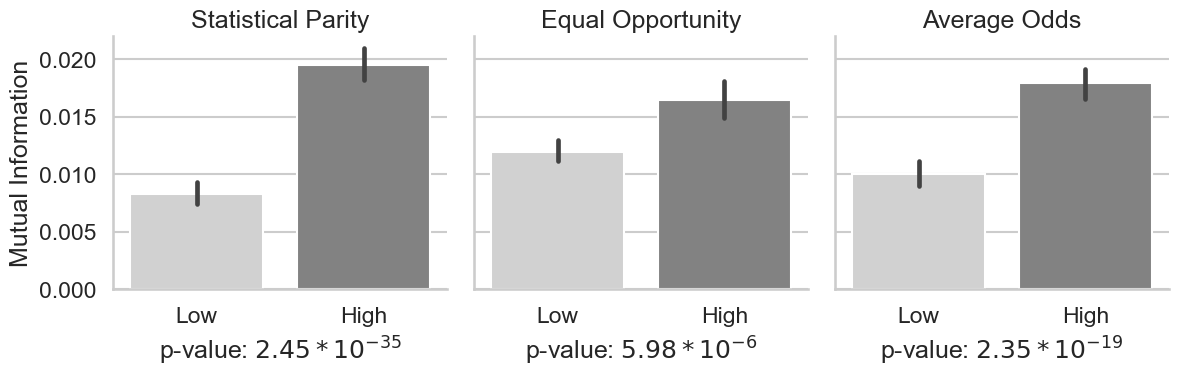

In [4]:
g = plot_differences(data, "mutual_info", "Mutual Information")
g.facet_axis(0, 0).set_xlabel(
    "p-value: $2.45*10^{-35}$", labelpad=5, fontdict={"fontsize": 18}
)
g.facet_axis(0, 1).set_xlabel(
    "p-value: $5.98*10^{-6}$", labelpad=5, fontdict={"fontsize": 18}
)
g.facet_axis(0, 2).set_xlabel(
    "p-value: $2.35*10^{-19}$", labelpad=5, fontdict={"fontsize": 18}
)
plt.savefig("figs/Mutual Information.pdf", bbox_inches="tight")
plt.show()

## Kendall's Tau

/Users/giord/miniconda3/envs/bias/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Ttest_indResult(statistic=4.651459793604828, pvalue=3.379080481050428e-06)
Ttest_indResult(statistic=1.6348618477556232, pvalue=0.10214231565563263)
Ttest_indResult(statistic=2.1351714378419446, pvalue=0.032792801118427854)
(0.06837939390738224, 'negligible')
(0.0007678701922359925, 'negligible')
(0.028023423053215535, 'negligible')


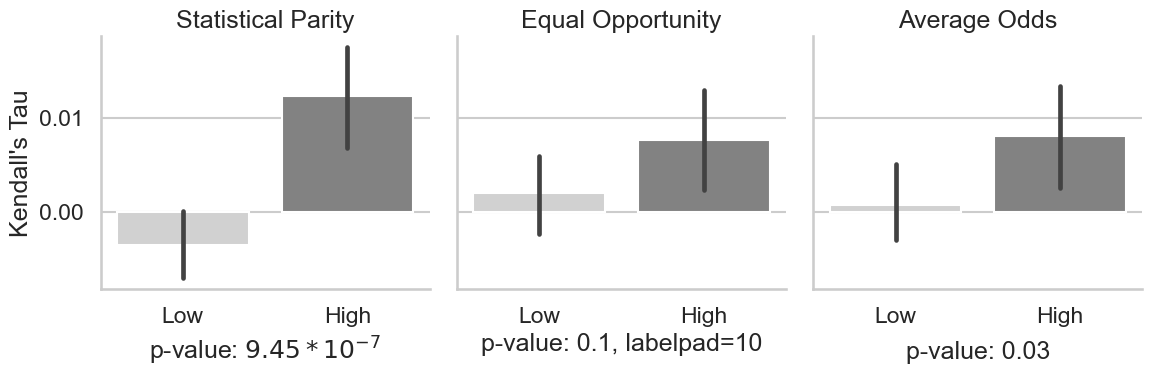

In [5]:
g = plot_differences(data, "correlation_true", "Kendall's Tau")

g.facet_axis(0,0).set_xlabel("p-value: $9.45*10^{-7}$", labelpad=5, fontdict={'fontsize': 18})
g.facet_axis(0, 1).set_xlabel(
    "p-value: 0.1, labelpad=10", fontdict={"fontsize": 18}
)
g.facet_axis(0, 2).set_xlabel(
    "p-value: 0.03", labelpad=10, fontdict={"fontsize": 18}
)
plt.savefig("figs/Kendall's Tau.pdf", bbox_inches="tight")
plt.show()

## Metrics Distribution

In [6]:
distr = pd.DataFrame(
    [
        {
            "Statistical Parity": [
              data[data["statistical_parity"] == 0].shape[0]/data.shape[0],
              data[data["statistical_parity"] == 1].shape[0]/data.shape[0],
            ],
            "Equal Opportunity": [
              data[data["equal_opportunity"] == 0].shape[0]/data.shape[0],
              data[data["equal_opportunity"] == 1].shape[0]/data.shape[0],
            ],
            "Average Odds": [
              data[data["average_odds"] == 0].shape[0]/data.shape[0],
              data[data["average_odds"] == 1].shape[0]/data.shape[0],
            ],
            "Bias": ["Low", "High"]
        }
    ]
)

In [7]:
distr = distr.explode(['Statistical Parity', 'Equal Opportunity', 'Average Odds', 'Bias']).melt(id_vars='Bias', var_name='Metric', value_name='Percentage')

/Users/giord/miniconda3/envs/bias/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/4c/mgvn0dc97_9gst9l7jbv9n640000gn/T/ipykernel_16596/2928899263.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


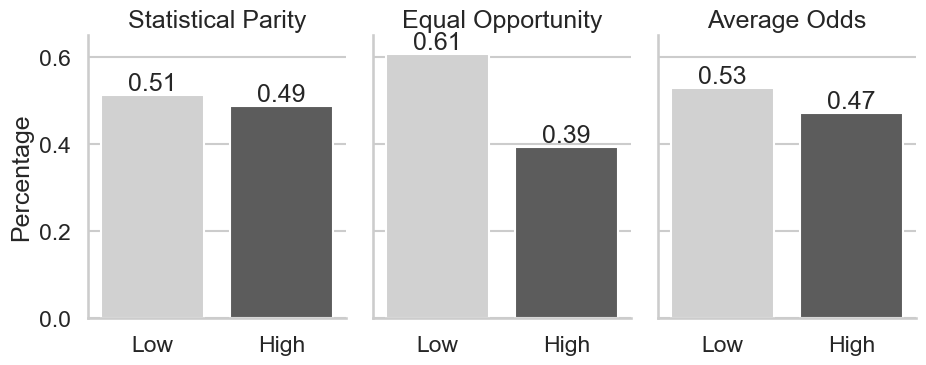

In [8]:
g = sns.catplot(
    data=distr,
    col="Metric",
    x="Bias",
    y="Percentage",
    kind="bar",
    hue="Bias",
    palette=sns.color_palette()[1:5:3],
    height=4,
    aspect=0.8,
)


for i in range(3):
    g.facet_axis(0, i).bar_label(g.facet_axis(0, i).containers[0], fmt="%.2f")
    g.facet_axis(0, i).bar_label(g.facet_axis(0, i).containers[1], fmt="%.2f")

g.set_titles("{col_name}")
# plt.subplots_adjust(top=1.3)
g.set_axis_labels("")
plt.ylim(0,0.65)
plt.tight_layout()
plt.savefig('metrics_distr.png', dpi=300, bbox_inches='tight')
plt.savefig("figs/metrics_distr.pdf", bbox_inches="tight")
plt.show()

## Distribution of SP, EO and AO

In [3]:
raw = pd.read_csv("../data/bias_symptoms_raw_logreg.csv", index_col=[0, 1])
metrics = raw[['statistical_parity', 'equal_opportunity', 'average_odds']]
metrics = pd.melt(metrics, var_name='Metric', value_name='Value')
metrics['Metric'] = metrics['Metric'].map({'statistical_parity': 'Statistical Parity', 'equal_opportunity': 'Equal Opportunity', 'average_odds': 'Average Odds'})
metrics['Value'] = metrics['Value'].abs()

In [6]:
raw[['statistical_parity', 'equal_opportunity', 'average_odds']].abs().describe()

,statistical_parity,equal_opportunity,average_odds
count,5930.000000,5893.000000,5930.000000
mean,0.223380,0.164061,0.212512
std,0.199799,0.190150,0.206985
min,0.000000,0.000000,0.000000
25%,0.039648,0.019323,0.021523
50%,0.196647,0.091837,0.129636
75%,0.369281,0.266667,0.357851
max,1.000000,0.999312,1.000000


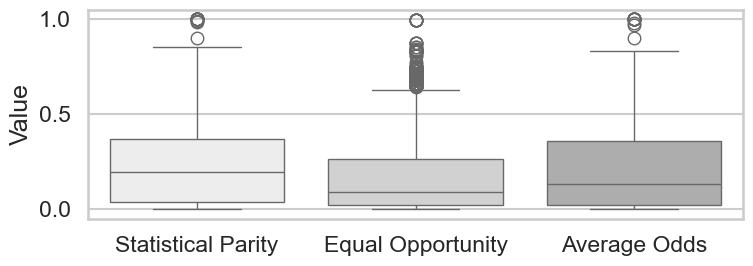

In [10]:
fig, ax = plt.subplots(figsize=(8, 3))
sns.boxplot(data=metrics, x='Metric', y='Value', hue='Metric')
plt.xlabel('')
plt.tight_layout()
plt.savefig('figs/metrics_boxplot.pdf', bbox_inches='tight')
plt.show()

## Feature selection with Boruta

In [11]:
data = pd.read_csv("../data/bias_symptoms_logreg.csv")

In [12]:
# Statistical parity

rf = RandomForestClassifier(n_jobs=-1, class_weight="balanced", max_depth=5)
feat_sel = BorutaPy(rf, n_estimators="auto", verbose=2)
feat_sel.fit(
    data.drop(
        columns=[
            "statistical_parity",
            "equal_opportunity",
            "average_odds",
            "variable",
            "data"
        ]
    ).values,
    data["statistical_parity"].values,
)
new_x = feat_sel.transform(
    data.drop(
        columns=[
            "statistical_parity",
            "equal_opportunity",
            "average_odds",
            "data",
            "variable",
        ]
    ).values
)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	13
Tentative: 	0
Rejected: 	0


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	13
Tentative: 	0
Rejected: 	0


In [13]:
# Equal opportunity

rf = RandomForestClassifier(n_jobs=-1, class_weight="balanced", max_depth=5)
feat_sel = BorutaPy(rf, n_estimators="auto", verbose=2)
feat_sel.fit(
    data.drop(
        columns=[
            "statistical_parity",
            "equal_opportunity",
            "average_odds",
            "variable",
            "data"
        ]
    ).values,
    data["equal_opportunity"].values,
)
new_x = feat_sel.transform(
    data.drop(
        columns=[
            "statistical_parity",
            "equal_opportunity",
            "average_odds",
            "data",
            "variable",
        ]
    ).values
)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	13
Tentative: 	0
Rejected: 	0


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	13
Tentative: 	0
Rejected: 	0


In [14]:
# Average odds

rf = RandomForestClassifier(n_jobs=-1, class_weight="balanced", max_depth=5)
feat_sel = BorutaPy(rf, n_estimators="auto", verbose=2)
feat_sel.fit(
    data.drop(
        columns=[
            "statistical_parity",
            "equal_opportunity",
            "average_odds",
            "variable",
            "data"
        ]
    ).values,
    data["average_odds"].values,
)
new_x = feat_sel.transform(
    data.drop(
        columns=[
            "statistical_parity",
            "equal_opportunity",
            "average_odds",
            "data",
            "variable",
        ]
    ).values
)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	13
Tentative: 	0
Rejected: 	0


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	13
Tentative: 	0
Rejected: 	0


## REDUN Algorithm

In [39]:
%%R -i data
library(tidyverse)
library(Hmisc)


data <- data %>% select(-data, -variable)
m <- redun(as.matrix(data, r2 = 0.8, nk = 0))
reducedData <- m$In
data <- data[, reducedData]
data %>% colnames()

 [1] "correlation_true"   "mutual_info"        "unpriv_prob_pos"   
 [4] "unpriv_unbalance"   "priv_unbalance"     "skew_var"          
 [7] "gini"               "simpson"            "shannon"           
[10] "ir"                 "pos_prob"           "statistical_parity"
[13] "equal_opportunity"  "average_odds"      


In [16]:
data_new = data[
    [
      "data", "variable",
        "correlation_true",
        "mutual_info",
        "unpriv_prob_pos",
        "unpriv_unbalance",
        "priv_unbalance",
        "statistical_parity",
        "equal_opportunity",
        "average_odds",
        "skew_var",
        "gini",
        "simpson",
        "shannon",
        "ir",
        "pos_prob"
    ]
]

In [17]:
data_new.columns

Index(['data', 'variable', 'correlation_true', 'mutual_info',
       'unpriv_prob_pos', 'unpriv_unbalance', 'priv_unbalance',
       'statistical_parity', 'equal_opportunity', 'average_odds', 'skew_var',
       'gini', 'simpson', 'shannon', 'ir', 'pos_prob'],
      dtype='object')

In [18]:
data.columns

Index(['variable', 'data', 'correlation_true', 'mutual_info',
       'unpriv_prob_pos', 'priv_prob_pos', 'unpriv_unbalance',
       'priv_unbalance', 'statistical_parity', 'equal_opportunity',
       'average_odds', 'kurtosis_var', 'skew_var', 'gini', 'simpson',
       'shannon', 'ir', 'pos_prob'],
      dtype='object')

In [19]:
data_new.to_csv("../data/bias_symptoms_logreg_reduced.csv", index=False)

## Correlation analysis

In [20]:
data = data_new

In [32]:
data

,data,variable,correlation_true,mutual_info,unpriv_prob_pos,unpriv_unbalance,priv_unbalance,skew_var,gini,simpson,shannon,ir,pos_prob,variance,covariance,statistical_parity,equal_opportunity,average_odds
0,arrhythmia,1,-0.329830,0.263048,0.250000,0.575000,1.326923,-0.272071,0.080404,0.029740,0.999956,0.769208,0.326923,0.245747,-0.841546,0.0,0.0,0.0
1,arrhythmia,23,0.071520,0.075555,0.454545,1.045455,0.000000,4.629568,0.110091,0.016495,0.999949,0.045361,0.454545,0.041588,-0.020290,1.0,1.0,1.0
2,arrhythmia,24,0.152653,0.042323,0.444444,1.022222,0.000000,6.782330,0.111328,0.015795,0.999947,0.022126,0.444444,0.021267,0.112077,1.0,1.0,1.0
3,arrhythmia,26,0.021056,0.055834,0.444444,1.022222,0.000000,6.782330,0.111328,0.015795,0.999947,0.022126,0.444444,0.021267,-0.043478,1.0,1.0,1.0
4,arrhythmia,38,0.110542,0.104732,0.444444,1.022222,0.000000,6.782330,0.111328,0.015795,0.999947,0.022126,0.444444,0.021267,0.089855,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5925,ibm,MaritalStatus_Divorced,-0.095871,0.005095,0.798319,0.977941,1.093750,1.592781,0.101727,0.002141,0.999786,0.235219,0.094538,0.154195,-0.014677,0.0,0.0,0.0
5926,ibm,MaritalStatus_Married,-0.058910,0.001746,0.794872,0.973718,1.029710,0.123947,0.085857,0.002951,0.999796,0.884604,0.045708,0.249063,-0.011462,0.0,0.0,0.0
5927,ibm,MaritalStatus_Single,0.141521,0.009645,0.855670,1.048196,0.906500,0.681858,0.093211,0.002687,0.999794,0.515416,0.115670,0.224444,0.026139,0.0,0.0,0.0
5928,ibm,OverTime_No,-0.306588,0.044253,0.645833,0.791146,1.101263,-0.747479,0.074244,0.002644,0.999793,0.484798,0.253157,0.219908,-0.056053,0.0,1.0,0.0


In [21]:
sp = data.pop('statistical_parity').abs()
eo = data.pop('equal_opportunity').abs()
ao = data.pop('average_odds').abs()

data.insert(len(data.columns), 'statistical_parity', sp)
data.insert(len(data.columns), 'equal_opportunity', eo)
data.insert(len(data.columns), 'average_odds', ao)

In [26]:
kendall = data.drop(columns=['variable', 'data']).corr("spearman").round(3)
for col in kendall.columns:
    for col2 in kendall.columns:
        pval = kendalltau(data[col], data[col2])[1]
        if np.abs(kendall.loc[col, col2]) > 0.95:
            kendall.loc[col, col2] = r"\cellcolor{black!25}\textbf{" + str(kendall.loc[col, col2]) + "}"
        if pval > 0.05:
            kendall.loc[col, col2] = f"{kendall.loc[col, col2]}*"

In [27]:
upper = kendall.where(np.triu(np.ones(kendall.shape), k=1).astype(bool))

In [28]:
upper

,correlation_true,mutual_info,unpriv_prob_pos,unpriv_unbalance,priv_unbalance,skew_var,gini,simpson,shannon,ir,pos_prob,statistical_parity,equal_opportunity,average_odds
correlation_true,NaN,0.047*,0.021,-0.077,-0.104,0.027*,0.029*,0.041,0.04,0.002*,0.07,0.059,0.001*,0.024*
mutual_info,NaN,NaN,0.207,0.123,-0.021*,-0.391,-0.391,0.38,0.375,0.414,0.46,0.218,0.045,0.143
unpriv_prob_pos,NaN,NaN,NaN,0.184,0.02*,-0.081,-0.073,0.783,0.782,0.181,0.141,0.028,0.206,-0.074
unpriv_unbalance,NaN,NaN,NaN,NaN,-0.687,0.035*,0.046*,0.041,0.041,0.068,0.0*,-0.009*,-0.021*,0.074
priv_unbalance,NaN,NaN,NaN,NaN,NaN,-0.162,-0.163,0.141,0.141,0.149,-0.106,-0.071,-0.009*,-0.272
skew_var,NaN,NaN,NaN,NaN,NaN,NaN,\cellcolor{black!25}\textbf{0.994},-0.333,-0.327,-0.877,0.4,0.315,0.461,0.178
gini,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.337,-0.331,-0.872,0.385,0.304,0.46,0.172
simpson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,\cellcolor{black!25}\textbf{0.999},0.412,0.1,0.011*,0.169,-0.11
shannon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.405,0.102,0.014*,0.173,-0.107
ir,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.458,-0.374,-0.496,-0.251


In [25]:
upper.to_latex('full_corr.tex', float_format="%.3f", escape=False, na_rep="-")